## Whisper-ASR

# Installing Whisper ASR
This command installs the Whisper ASR library directly from its GitHub repository. The `-q` flag ensures that the installation process runs quietly, displaying minimal output. Whisper is a powerful Automatic Speech Recognition (ASR) model developed by OpenAI.


In [1]:
!pip install git+https://github.com/openai/whisper.git -q

# Importing Libraries and Loading the Whisper Model

1. **Import Libraries**:
   - `whisper`: For working with the Whisper ASR model.
   - `os`: For interacting with the operating system (e.g., file paths).
   - `numpy`: For numerical computations and handling arrays.
   - `sklearn.metrics`: For evaluating model performance using metrics like accuracy and confusion matrices.
   - `matplotlib.pyplot`: For visualizing data and results.

2. **Load Whisper Model**:
   - The Whisper model is initialized with the "base" version using `whisper.load_model("base")`. 
   - The "base" version is a balance between performance and computational efficiency.

3. **Confusion Matrix Import**:
   - The `confusion_matrix` function from `sklearn.metrics` is imported to analyze the performance of language predictions by visualizing misclassifications.


In [ ]:
import whisper
import os
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
model = whisper.load_model("base")
from sklearn.metrics import confusion_matrix


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 80.3MiB/s]


# Language Identification Using Whisper ASR

### 1. **Function: `process_audio_file`**
   - **Purpose**: Prepares audio files for processing by the Whisper model.
   - **Steps**:
     - Loads the audio file using `whisper.load_audio`.
     - Pads or trims the audio to a fixed duration using `whisper.pad_or_trim`.
     - Converts the audio to a log-mel spectrogram using `whisper.log_mel_spectrogram`.
     - Moves the spectrogram to the device (e.g., CPU/GPU) where the model is loaded.

### 2. **Dataset and Language Mapping**
   - `data_dir`: Directory containing the audio files, assumed to be organized by language directories.
   - `language_mapping`: Maps Whisper's predicted language codes (e.g., "de") to corresponding full language names (e.g., "german"). Languages not in the mapping are categorized as "other."

### 3. **Processing Audio Files**
   - **File Traversal**:
     - Traverses subdirectories under `data_dir`.
     - Processes up to 100 `.wav` files per directory for performance considerations.
   - **Mel Spectrogram Extraction**: Calls `process_audio_file` to extract features for each audio file.
   - **Language Detection**:
     - Uses `model.detect_language(mel)` to predict the language.
     - Finds the language with the highest probability (`max(probs, key=probs.get)`).
     - Assigns languages not in `language_mapping` to "other."

### 4. **Ground Truth and Predictions**
   - **Ground Truth**: Extracted from the file name, assuming a naming format like `language_something.wav`.
   - **Predictions**: Translated from Whisper's language codes to full names using `language_mapping`.

### 5. **Accuracy Calculation**
   - **Metric**: `accuracy_score` from `sklearn.metrics` is used to compute the proportion of correct predictions.
   - **Output**: The script prints the accuracy of the language identification.

### 6. **Key Assumptions**
   - File names follow a consistent format where the language code is the prefix (e.g., `de_filename.wav`).
   - Audio files are `.wav` format.
   - Each subdirectory under `data_dir` corresponds to a specific language.


In [ ]:


def process_audio_file(file_path):
    audio = whisper.load_audio(file_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    return mel

data_dir = "/kaggle/input/languages"
language_mapping = {
    "de": "german",
    "gu": "gujarati",
    "hi": "hindi",
    "it": "italian",
    "ja": "japanese",
    "ru": "russian",
    "sa": "sanskrit",
    "es": "spanish",
    "other": "other"
}

ground_truth = []
predicted_labels = []

for root, dirs, files in os.walk(data_dir):
    for directory in dirs:
        directory_path = os.path.join(root, directory)
        i = 0 
        for file_name in os.listdir(directory_path):
            if i == 100:
                break
            file_path = os.path.join(directory_path, file_name)
            if file_path.endswith(".wav"):
                mel = process_audio_file(file_path)

                _, probs = model.detect_language(mel)
                predicted_language = max(probs, key=probs.get)

                if predicted_language not in language_mapping:
                    predicted_language = "other"

                ground_truth_language = file_name.split("_")[0]  # Assuming file names are like "language.wav"

                ground_truth.append(ground_truth_language)
                predicted_labels.append(predicted_language)
                i += 1  

                
predicted_labels = [language_mapping[l] for l in predicted_labels]

accuracy = accuracy_score(ground_truth, predicted_labels)
print("Accuracy:", accuracy)


Accuracy: 0.805


# Confusion Matrix for Language Identification

### 1. **Confusion Matrix Calculation**
   - **Purpose**: Evaluate the performance of the model by analyzing its predictions.
   - **Details**:
     - `confusion_matrix` from `sklearn.metrics` compares the ground truth labels (`ground_truth`) with the predicted labels (`predicted_labels`).
     - The `labels` parameter ensures the matrix rows and columns align with the languages in `language_mapping`.

### 2. **Visualization**
   - **Plotting the Matrix**:
     - The confusion matrix is visualized as a heatmap using `plt.imshow` with the `Blues` colormap.
     - A color bar is added to indicate the scale of values.
   - **Annotations**:
     - **Title**: "Confusion Matrix" for context.
     - **X-axis**: Represents the predicted labels.
     - **Y-axis**: Represents the true labels.
     - **Tick Labels**: Language names (from `language_mapping`) are displayed on both axes for clarity.
   - **Formatting**:
     - The figure is sized appropriately (`10x8`) for readability.
     - X-axis labels are rotated (`45°`) to prevent overlap.

### 3. **Insights from the Confusion Matrix**
   - The diagonal cells represent correctly classified samples (true positives for each language).
   - Off-diagonal cells indicate misclassifications, showing which languages were confused with others.
   - The matrix provides a detailed view of the model's strengths and areas needing improvement.

### 4. **Interactive Component**
   - By visually inspecting the heatmap, patterns in misclassification can be identified and potentially addressed in future model refinements.


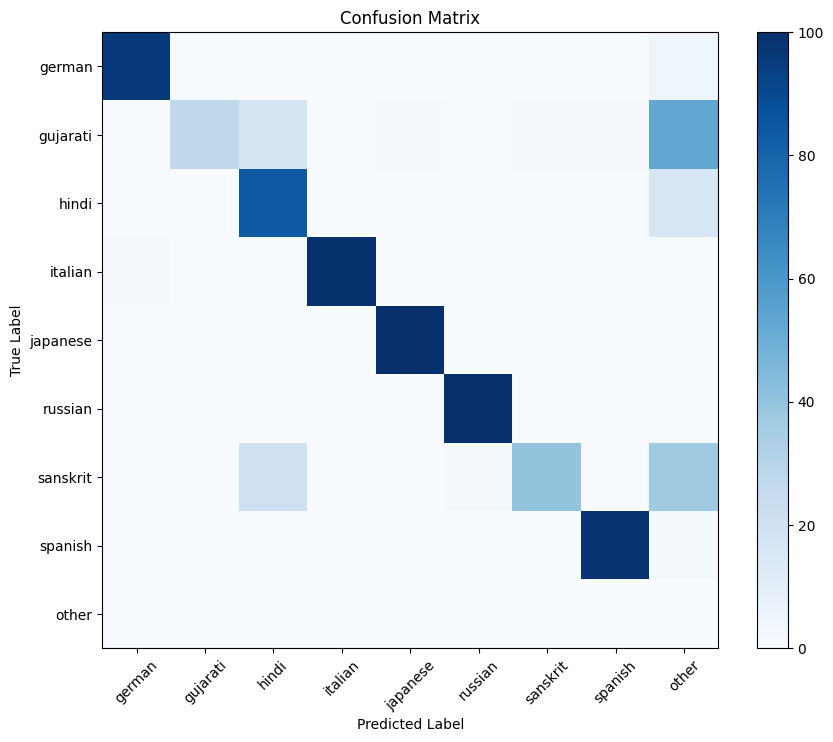

In [ ]:

conf_matrix = confusion_matrix(ground_truth, predicted_labels, labels=list(language_mapping.values()))

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(language_mapping)), list(language_mapping.values()), rotation=45)
plt.yticks(np.arange(len(language_mapping)), list(language_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Loading the Whisper Model: "Small" Version

- **Whisper Model**: The model is reloaded using the "small" variant by calling `whisper.load_model("small")`.
- **Purpose**: The "small" version is more robust and accurate than the "base" version, though it requires more computational resources. This change is likely made to improve the performance of language identification in subsequent evaluations.


In [6]:
model = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:10<00:00, 44.3MiB/s]


# Language Identification with Enhanced Whisper Model

### 1. **Function: `process_audio_file`**
   - Processes an audio file to generate its log-mel spectrogram, suitable for input to the Whisper model.
   - **Steps**:
     - Loads the audio file using `whisper.load_audio`.
     - Pads or trims the audio to a standard length for consistent processing.
     - Converts the audio to a log-mel spectrogram and moves it to the same device as the model.

### 2. **Dataset and Language Mapping**
   - **Dataset**: Audio files are organized in the directory `/kaggle/input/languages`, with subdirectories for each language.
   - **Language Mapping**: Maps Whisper's language codes (e.g., "de") to full names (e.g., "german"). Predictions outside the mapping are categorized as "other."

### 3. **Processing Audio Files**
   - Traverses the dataset directory and processes `.wav` files:
     - Limits processing to 100 files per language directory for computational efficiency.
     - Extracts the `mel` spectrogram from each audio file.
   - Predicts the language using Whisper's `detect_language` method:
     - Finds the language with the highest probability from the model's predictions.
     - If the predicted language is not in `language_mapping`, assigns it as "other."

### 4. **Ground Truth and Predictions**
   - **Ground Truth**: Extracted from the file name, assuming the format includes the language as a prefix (e.g., `de_filename.wav`).
   - **Predicted Labels**: Translates Whisper's language codes into their full names using `language_mapping`.

### 5. **Accuracy Calculation**
   - **Metric**: Uses `accuracy_score` from `sklearn.metrics` to calculate how many predictions matched the ground truth.
   - **Output**: Prints the accuracy of the language identification model.

### 6. **Improvements with the "Small" Model**
   - This script uses the Whisper "small" model, offering improved accuracy compared to the "base" version. The trade-off is higher computational demand, which is balanced by limiting the number of processed files.

### 7. **Key Assumptions**
   - Audio files are in `.wav` format.
   - File names follow a consistent format with language codes as prefixes.
   - Dataset structure has subdirectories for each language, containing corresponding audio files.


In [ ]:
def process_audio_file(file_path):
    audio = whisper.load_audio(file_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    return mel

data_dir = "/kaggle/input/languages"
language_mapping = {
    "de": "german",
    "gu": "gujarati",
    "hi": "hindi",
    "it": "italian",
    "ja": "japanese",
    "ru": "russian",
    "sa": "sanskrit",
    "es": "spanish",
    "other": "other"
}
ground_truth = []
predicted_labels = []

for root, dirs, files in os.walk(data_dir):
    for directory in dirs:
        directory_path = os.path.join(root, directory)
        i = 0  
        for file_name in os.listdir(directory_path):
            if i == 100:
                break
            file_path = os.path.join(directory_path, file_name)
#             print(file_path)
            if file_path.endswith(".wav"):
                mel = process_audio_file(file_path)

                _, probs = model.detect_language(mel)
                predicted_language = max(probs, key=probs.get)

                if predicted_language not in language_mapping:
                    predicted_language = "other"

                ground_truth_language = file_name.split("_")[0]  

                ground_truth.append(ground_truth_language)
                predicted_labels.append(predicted_language)
                i += 1  

                
predicted_labels = [language_mapping[l] for l in predicted_labels]

accuracy = accuracy_score(ground_truth, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.85875


# Visualizing Model Performance with a Confusion Matrix

### 1. **Confusion Matrix Construction**
   - **Purpose**: To evaluate the model's performance by showing how often each language was correctly or incorrectly predicted.
   - **Details**:
     - `confusion_matrix` compares the true language labels (`ground_truth`) with the predicted labels (`predicted_labels`).
     - The `labels` parameter ensures the matrix rows and columns correspond to the languages defined in `language_mapping`.

### 2. **Heatmap Visualization**
   - **Plotting**:
     - The confusion matrix is visualized as a heatmap using `plt.imshow`.
     - The `Blues` colormap highlights the frequency of predictions, where darker shades indicate higher values.
   - **Axes and Annotations**:
     - **Title**: "Confusion Matrix" to indicate the purpose of the plot.
     - **X-axis**: Represents the predicted language labels.
     - **Y-axis**: Represents the true language labels.
     - **Tick Labels**: Displays language names (from `language_mapping`) for both axes, improving readability.
     - **Colorbar**: A scale indicating the range of values in the matrix.

### 3. **Formatting**
   - The figure size (`10x8`) ensures clarity and readability.
   - X-axis labels are rotated by `45°` to avoid overlap.

### 4. **Interpretation**
   - **Diagonal Cells**: Represent correct predictions (e.g., true positives for each language).
   - **Off-Diagonal Cells**: Indicate misclassifications, showing which languages were confused.
   - The heatmap provides insights into the model's strengths and areas for improvement, guiding further optimization efforts.

### 5. **Use Case**
   - This confusion matrix visualization helps in analyzing the nuances of the model's performance and identifying patterns in misclassification.


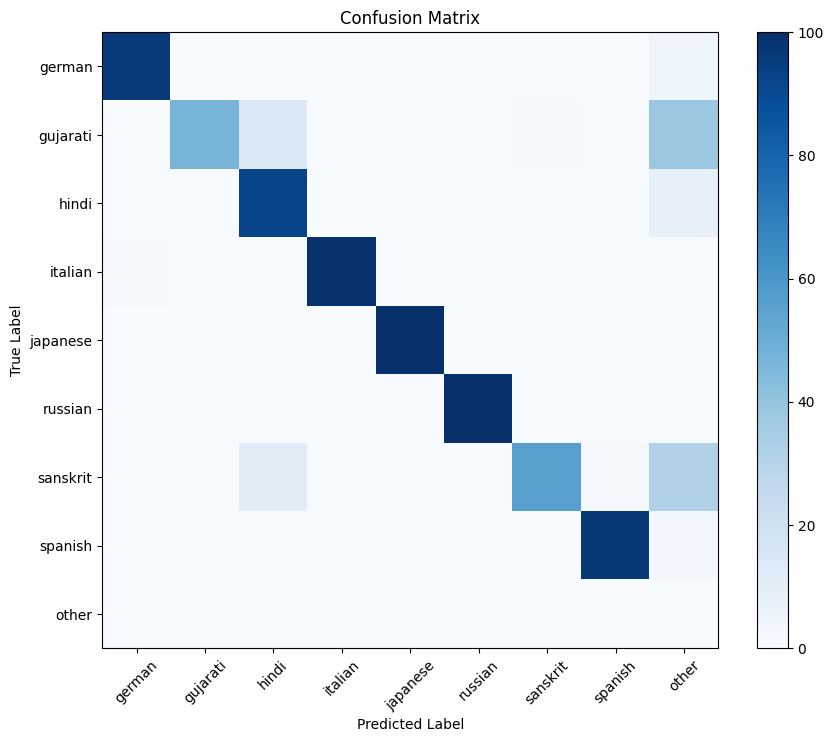

In [8]:
conf_matrix = confusion_matrix(ground_truth, predicted_labels, labels=list(language_mapping.values()))

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(language_mapping)), list(language_mapping.values()), rotation=45)
plt.yticks(np.arange(len(language_mapping)), list(language_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Upgrading to Whisper "Medium" Model

- **Model Update**: The Whisper model is now loaded using the "medium" variant with the command `whisper.load_model("medium")`.
- **Purpose**:
  - The "medium" model offers better accuracy and robustness than the "small" and "base" versions.
  - It is designed to handle more complex tasks and larger datasets effectively.
- **Trade-offs**:
  - Increased computational and memory requirements.
  - Longer inference times compared to smaller variants.
- **Reason for Upgrade**:
  - To improve the model's performance in language identification, particularly for nuanced distinctions between languages.


In [9]:
model = whisper.load_model("medium")

100%|█████████████████████████████████████| 1.42G/1.42G [00:27<00:00, 54.6MiB/s]


# Language Identification: Feature Extraction and Model Evaluation

### 1. **Function: `process_audio_file`**
   - **Purpose**: Extracts features from audio files to prepare them for language identification by the Whisper model.
   - **Steps**:
     1. Loads the audio file using `whisper.load_audio`.
     2. Pads or trims the audio to a standard length for consistent processing.
     3. Converts the audio into a log-mel spectrogram, the input format expected by the Whisper model.
     4. Transfers the spectrogram to the device (e.g., GPU) where the model is loaded.

### 2. **Dataset and Language Mapping**
   - **Dataset**: Audio files are stored in `/kaggle/input/languages`, organized by subdirectory for each language.
   - **Mapping**: 
     - `language_mapping` maps Whisper's predicted language codes to readable language names (e.g., `"de"` to `"german"`).
     - Languages not present in the mapping are classified as `"other"`.

### 3. **Processing Pipeline**
   - **Data Traversal**:
     - Iterates over subdirectories in the dataset.
     - Processes up to 100 `.wav` files per language directory to maintain efficiency.
   - **Feature Extraction**: Each file is passed to `process_audio_file` to generate its spectrogram.
   - **Language Detection**:
     - The Whisper model predicts the probabilities of various languages using `model.detect_language`.
     - The language with the highest probability is selected as the prediction.
   - **Handling Unknown Predictions**:
     - If a language is not found in the mapping, it is categorized as `"other"`.

### 4. **Ground Truth and Predictions**
   - **Ground Truth**:
     - Extracted from file names, assuming a naming convention where the language code is the prefix (e.g., `de_filename.wav`).
   - **Predicted Labels**:
     - Translated from Whisper's language codes to full names using `language_mapping`.

### 5. **Accuracy Calculation**
   - **Metric**: Uses `accuracy_score` from `sklearn.metrics` to measure how often the predicted labels match the ground truth.
   - **Result**: The accuracy score is printed, providing a quantitative evaluation of the model's language identification performance.

### 6. **Highlights**
   - Combines audio preprocessing, feature extraction, and model inference in a streamlined pipeline.
   - Facilitates evaluation by matching predictions with ground truth and computing accuracy.
   - Processes large datasets efficiently by limiting file count per language.


In [ ]:

# Function to load audio files and extract features
def process_audio_file(file_path):
    audio = whisper.load_audio(file_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    return mel

data_dir = "/kaggle/input/languages"
language_mapping = {
    "de": "german",
    "gu": "gujarati",
    "hi": "hindi",
    "it": "italian",
    "ja": "japanese",
    "ru": "russian",
    "sa": "sanskrit",
    "es": "spanish",
    "other": "other"
}
ground_truth = []
predicted_labels = []

for root, dirs, files in os.walk(data_dir):
    for directory in dirs:
        directory_path = os.path.join(root, directory)
        i = 0  
        for file_name in os.listdir(directory_path):
            if i == 100:
                break
            file_path = os.path.join(directory_path, file_name)
#             print(file_path)
            if file_path.endswith(".wav"):
                mel = process_audio_file(file_path)

                _, probs = model.detect_language(mel)
                predicted_language = max(probs, key=probs.get)

                if predicted_language not in language_mapping:
                    predicted_language = "other"
                
                ground_truth_language = file_name.split("_")[0]  

                ground_truth.append(ground_truth_language)
                predicted_labels.append(predicted_language)
                i += 1  

                
predicted_labels = [language_mapping[l] for l in predicted_labels]
# print(predicted_labels)
accuracy = accuracy_score(ground_truth, predicted_labels)
print("Accuracy:", accuracy)

['japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'japanese', 'ja

# Confusion Matrix Visualization for Model Performance

### 1. **Confusion Matrix Calculation**
   - **Purpose**: To evaluate the model's predictions against the ground truth and visualize misclassifications.
   - **Details**: 
     - The confusion matrix is generated using `confusion_matrix`, comparing the true labels (`ground_truth`) with the predicted labels (`predicted_labels`).
     - `labels=list(language_mapping.values())` ensures that the matrix is computed for all languages in the `language_mapping`.

### 2. **Plotting the Confusion Matrix**
   - **Visualization**: The confusion matrix is visualized using `matplotlib`'s `imshow` function with the `Blues` colormap to display the frequency of predictions.
   - **Formatting**:
     - The plot size is set to `(10, 8)` to ensure clarity.
     - **Colorbar**: Represents the scale of values within the matrix.
     - **X-axis**: Displays the predicted language labels.
     - **Y-axis**: Displays the true language labels.
     - **Rotation of X-axis labels**: `45°` rotation ensures the labels are readable.
     - The matrix helps identify patterns in model performance, such as which languages are most frequently confused.

### 3. **Interpretation of Results**
   - **Diagonal Cells**: Represent correct predictions, where the predicted label matches the true label.
   - **Off-Diagonal Cells**: Indicate misclassifications, highlighting which languages were confused with each other.
   - **Insights**: The confusion matrix allows for a deeper understanding of the model's strengths and weaknesses, helping to pinpoint specific languages that might need additional attention or data to improve classification accuracy.

### 4. **Purpose of the Plot**
   - This heatmap provides a clear, graphical representation of the model's performance, complementing the accuracy score and enabling a more detailed analysis of classification errors.


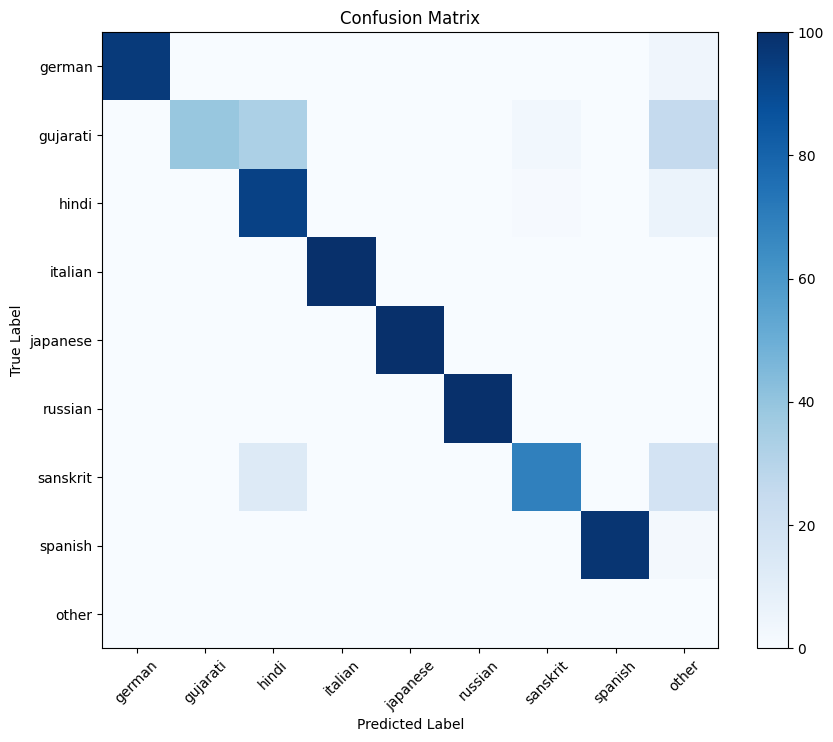

In [11]:
conf_matrix = confusion_matrix(ground_truth, predicted_labels, labels=list(language_mapping.values()))

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(language_mapping)), list(language_mapping.values()), rotation=45)
plt.yticks(np.arange(len(language_mapping)), list(language_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()